# Machine Learning portfolio opdracht 3

Teamnaam: Ongeneeselijk muziekaal

Teamleden:
1. needanku (Tijn)
2. jipschijvenaars (Jip)
3. joesvandeursen (Joes)
4. jimaugustinus (Jim)


#### Import libraries

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from IPython.display import Audio, display


# Opdr 1. Feature enginering

#### data laden en verkennen

In [48]:
labels_df = pd.read_csv('labels_new.csv')
display(labels_df.head())


filename    genre
0  m00248.wav    metal
1  m00230.wav  country
2  m00637.wav   hiphop
3  m00627.wav    metal
4  m00138.wav   reggae

In [49]:
print("Verdeling Genres:")
print("-" * 17)
print(labels_df['genre'].value_counts())
print("\nTotaal aantal samples:", len(labels_df))
print("Aantal verschillende genres:", labels_df['genre'].nunique())

Verdeling Genres:
-----------------
genre
metal        5
country      5
hiphop       5
reggae       5
classical    5
jazz         5
rock         5
pop          5
blues        5
disco        5
Name: count, dtype: int64

Totaal aantal samples: 50
Aantal verschillende genres: 10


In [50]:
# 
labeled_audio_dir = Path('labeled')
# 
labeled_audio_files = os.listdir(labeled_audio_dir)

## Een dataframe met audiofeatures


In [51]:
class AudioFeatureExtractor:
    def __init__(self, audio_dir):
        self.audio_dir = Path(audio_dir)
        self.features_list = []
        
    def extract_features(self, audio_files):
        for filename in audio_files:
            file_path = self.audio_dir / filename
            features = self.process_file(file_path, filename)
            self.features_list.append(features)
        return pd.DataFrame(self.features_list)
    
    def process_file(self, file_path, filename):
        y, sr = librosa.load(file_path)
        
        # 
        # https://librosa.org/doc/latest/feature.html
        features = {
            'filename': filename,
            'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            'spectral_bandwidth_std': np.std(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            'spectral_centroid_std': np.std(librosa.feature.spectral_centroid(y=y, sr=sr)),
            'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y)),
            'zero_crossing_rate_std': np.std(librosa.feature.zero_crossing_rate(y)),
            'rms': np.mean(librosa.feature.rms(y=y)),
            'rms_std': np.std(librosa.feature.rms(y=y)),
            'rolloff': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            'flatness': np.mean(librosa.feature.spectral_flatness(y=y)),
            'tempo': librosa.feature.rhythm.tempo(y=y, sr=sr)[0],
        }
        
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
        features.update({
            'onset_strength_mean': np.mean(onset_env),
            'onset_strength_std': np.std(onset_env),
            'beat_strength': np.mean(librosa.util.normalize(onset_env)[beats]) if len(beats) > 0 else 0
        })
        
        harmonic, percussive = librosa.effects.hpss(y)
        features.update({
            'harmonic_ratio': np.mean(np.abs(harmonic)) / (np.mean(np.abs(percussive))),
            'percussive_ratio': np.mean(np.abs(percussive)) / (np.mean(np.abs(harmonic)))
        })
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}'] = np.mean(mfcc[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfcc[i])
        
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        for i in range(12):
            features[f'chroma_{i+1}'] = np.mean(chroma[i])
            features[f'chroma_{i+1}_std'] = np.std(chroma[i])
        
    
        tempogram = librosa.feature.tempogram(y=y, sr=sr)
        features.update({
            'tempogram_ratio': np.mean(tempogram) / (np.std(tempogram)),
            'tempogram_std': np.std(tempogram)
        })
        
        return features
    
    def merge_with_labels(self, labels_df):
        features_df = pd.DataFrame(self.features_list)
        return pd.merge(features_df, labels_df, on='filename')

extractor = AudioFeatureExtractor(labeled_audio_dir)
features_df = extractor.extract_features(labeled_audio_files)
audio_features_df = extractor.merge_with_labels(labels_df)

display(audio_features_df.head())


filename  spectral_bandwidth  spectral_bandwidth_std  spectral_centroid  \
0  m00002.wav         1920.270843              352.469828        1451.862124   
1  m00039.wav         2019.300256              442.196748        1811.410394   
2  m00041.wav         2992.010638              346.836989        3110.898196   
3  m00072.wav         2709.897108              360.419232        2624.814629   
4  m00096.wav         2485.524548              368.525304        2549.269757   

   spectral_centroid_std  zero_crossing_rate  zero_crossing_rate_std  \
0             428.935223            0.051224                0.025074   
1             809.772584            0.072150                0.051697   
2             779.418889            0.152857                0.068744   
3             585.287392            0.120217                0.038883   
4             695.078336            0.115834                0.050427   

        rms   rms_std      rolloff  ...  chroma_9_std  chroma_10  \
0  0.050480  0.027131  3047.431199  ...      0.377096   0.287583   
1  0.123665  0.053056  3854.851374  ...      0.223918   0.297682   
2  0.198322  0.077807  6744.988603  ...      0.323897   0.332073   
3  0.142927  0.062914  5605.777240  ...      0.329127   0.282717   
4  0.184340  0.098477  5583.144894  ...      0.298731   0.244928   

   chroma_10_std  chroma_11  chroma_11_std  chroma_12  chroma_12_std  \
0       0.328681   0.224478       0.326612   0.185700       0.306980   
1       0.275615   0.422818       0.337206   0.401892       0.297101   
2       0.237859   0.445475       0.354692   0.293710       0.220588   
3       0.175517   0.376277       0.294601   0.277690       0.236222   
4       0.281050   0.239062       0.275884   0.318006       0.307679   

   tempogram_ratio  tempogram_std   genre  
0         0.869013       0.200426    jazz  
1         0.747660       0.139721  reggae  
2         0.802305       0.187328     pop  
3         0.806668       0.193607   disco  
4         0.729187       0.165431   disco  

[5 rows x 70 columns]

In [52]:
audio_features_df[['harmonic_ratio', 'percussive_ratio', 'tempogram_ratio']].head(10)

harmonic_ratio  percussive_ratio  tempogram_ratio
0        9.361988          0.106815         0.869013
1        2.115955          0.472600         0.747660
2        1.639182          0.610060         0.802305
3        1.536361          0.650889         0.806668
4        1.093956          0.914114         0.729187
5        9.940834          0.100595         0.899793
6        3.059224          0.326880         0.702203
7        1.392032          0.718374         0.742768
8        3.141489          0.318320         0.889178
9        1.131521          0.883766         0.855859

https://librosa.org/doc/latest/feature.html

1. **Spectral Bandwidth**
- Meet de breedte van het frequentiebereik in het geluidssignaal
- Berekend als gewogen standaardafwijking van frequenties t.o.v. het spectrale zwaartepunt

2. **Spectral Centroid**
- Het "massamiddelpunt" van het spectrum, indicatie voor helderheid van het geluid
- Berekend als gewogen gemiddelde van aanwezige frequenties

3. **Zero Crossing Rate**
- Hoe vaak het signaal de nullijn kruist (van positief naar negatief of omgekeerd)
- Telt het aantal keren dat het signaal van teken wisselt

4. **Root Mean Square Energy**
- Gemiddelde energie/volume van het signaal
- Berekend als kwadratisch gemiddelde van de amplitude

5. **Spectral Rolloff**
- Frequentie waaronder het merendeel van de energie zich bevindt 
- Hier: frequentie waaronder 85% van de energie ligt

6. **MFCC**
- Representatie van kortetermijn vermogensspectrum
- Gebaseerd op cosinustransformatie van mel-geschaald logaritmisch vermogensspectrum

7. **Chroma Features**
- Verdeling van toonhoogtes over 12 halve tonen
- Geeft aan welke toonhoogtes prominent aanwezig zijn

8. **Spectral Flatness**
- Meet hoe "tonaal" vs. "ruisachtig" het geluid is
- Ratio tussen geometrisch en rekenkundig gemiddelde van spectrum

9. **Tempo**
- Geschatte snelheid van de muziek in BPM (beats per minute)
- Berekend uit ritmische patronen

10. **Tempogram Ratio**
- Verhouding tussen gemiddelde en standaardafwijking van het tempogram
- Geeft aan hoe constant het tempo is

# Opdr 2: Unsupervised Learning

In [53]:
# 
unlabeled_audio_dir = Path('unlabeled')
# 
unlabeled_audio_files = os.listdir(unlabeled_audio_dir)

## Aantal clusters bepalen in de unlabeled dataset met K-means

c:\Users\tijnw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\tijnw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\tijnw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\tijnw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

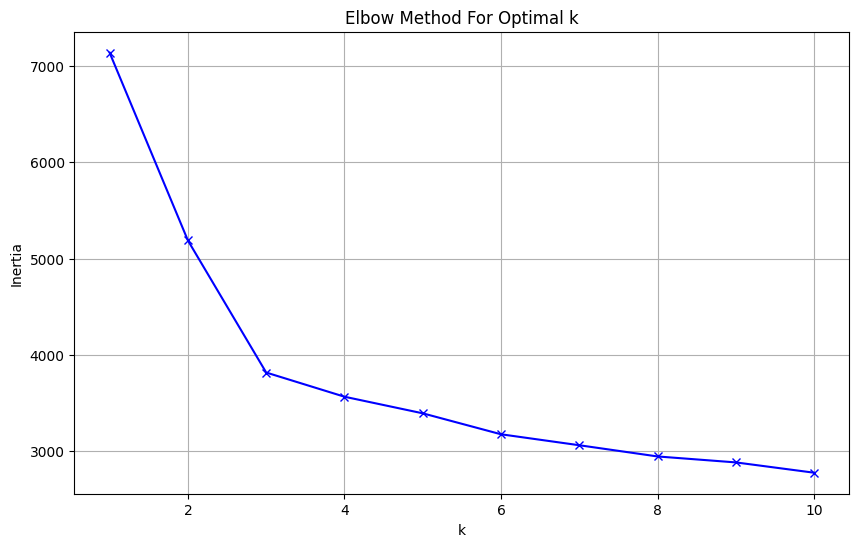

In [54]:
unlabeled_extractor = AudioFeatureExtractor(unlabeled_audio_dir)
unlabeled_features = unlabeled_extractor.extract_features(unlabeled_audio_files)

X = unlabeled_features.drop('filename', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [55]:
inertias

[7139.999999999999,
 5188.17257321821,
 3815.4660523201055,
 3564.044284005598,
 3391.4096420184296,
 3173.5133699897888,
 3059.583939587157,
 2943.016404790734,
 2881.1189464880167,
 2773.961273369971]

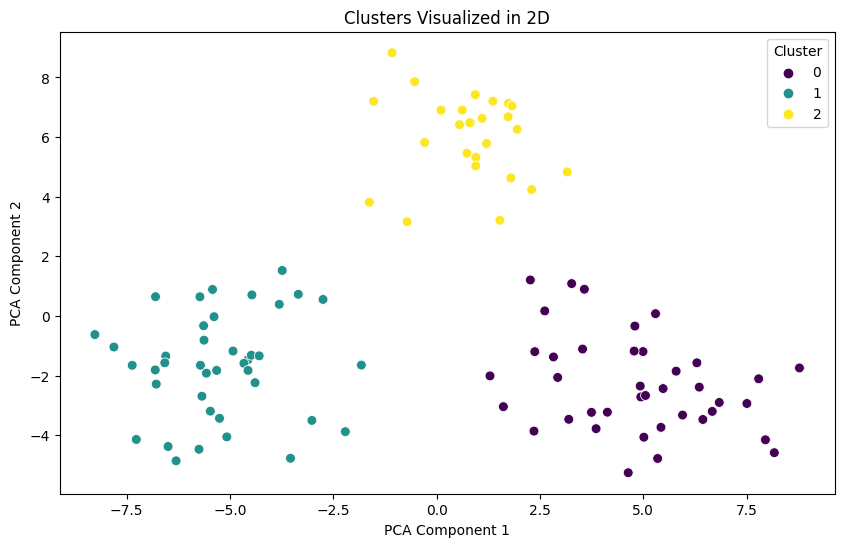

In [14]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=50)
plt.title('Clusters Visualized in 2D')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


## Waarom is KMeans met k=3 de beste keuze?

KMeans met k=3 is de beste keuze omdat de inertia het meest afneemt bij k=3.
Dit betekent dat de clusters het beste worden gevormd met 3 clusters.
Daarnaast is het ook belangrijk om te kijken naar de visualisatie van de clusters in 2D.
Hier zien we dat de clusters goed van elkaar gescheiden zijn en dat er geen overlap is tussen de clusters.
Dit betekent dat de clusters goed zijn gevormd en dat er een duidelijk onderscheid is tussen de verschillende clusters.
Daarom is KMeans met k=3 de beste keuze voor dit probleem.


In [15]:
cluster_assignments = pd.DataFrame({
    'filename': unlabeled_features['filename'],
    'cluster': clusters
})

cluster_assignments = cluster_assignments.sort_values('filename')

print("Sample cluster assignments:")
display(cluster_assignments.head())

print("\nCluster distribution:")
print(cluster_assignments['cluster'].value_counts().sort_index())

Sample cluster assignments:


filename  cluster
0  m00003.wav        2
1  m00012.wav        2
2  m00013.wav        1
3  m00043.wav        2
4  m00044.wav        1


Cluster distribution:
cluster
0    39
1    40
2    26
Name: count, dtype: int64


## Leg de wiskundige werking van het clustering algoritme uit met een voorbeeld.

Het K-means clustering algoritme is een algoritme dat punten in een dataset verdeelt in K clusters. 

Het algoritme werkt als volgt:
1. K punten worden willekeurig gekozen als beginpunten van de clusters.
2. Voor elk punt in de dataset wordt berekend tot welk cluster het punt het dichtst bij ligt.
3. De gemiddelde positie van de punten in elk cluster wordt berekend.
4. De beginpunten van de clusters worden verplaatst naar de gemiddelde posities.
5. Stap 2 t/m 4 worden herhaald totdat de clusters niet meer veranderen.
6. De clusters zijn nu gevormd.


### Voorbeeld:
Stel dat we de volgende dataset hebben: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

We willen deze dataset verdelen in 2 clusters.

We kiezen willekeurig 2 beginpunten: 2 en 8.

De punten worden verdeeld in clusters:

Cluster 1: [1, 2, 3, 4, 5, 6]

Cluster 2: [7, 8, 9, 10]

De gemiddelde posities zijn 3.5 en 8.5.


De clusters worden nu:

Cluster 1: [1, 2, 3, 4, 5, 6]

Cluster 2: [7, 8, 9, 10]

De gemiddelde posities zijn 3.5 en 8.5.

De clusters zijn nu gevormd.



## De 3 clusters

In [26]:
audio_files_to_play = [
    (r'unlabeled\m00055.wav', 0),
    (r'unlabeled\m00069.wav', 1),
    (r'unlabeled\m00012.wav', 2)
]

for file_path, cluster_number in audio_files_to_play:
    print(f"Playing file from cluster number: {cluster_number}")
    display(Audio(filename=file_path))

Playing file from cluster number: 0


Playing file from cluster number: 1


Playing file from cluster number: 2


In [ ]:
cluster_assignments['genre'] = cluster_assignments['cluster'].map({
    0: 'pop',
    1: 'classical',
    2: 'metal'
})

Score: 0.98113

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def recommend_similar_songs(audio_file, features_df, n_recommendations=5):
    """
    Recommend similar songs based on audio features
    
    Parameters:
    audio_file: str - filename of the target audio file
    features_df: DataFrame - dataframe containing audio features
    n_recommendations: int - number of recommendations to return
    """
    
    # Get features excluding filename column
    features = features_df.drop('filename', axis=1)
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Find the index of the target song
    target_idx = features_df[features_df['filename'] == audio_file].index[0]
    
    # Initialize and fit KNN
    nn = NearestNeighbors(n_neighbors=n_recommendations+1)  # +1 because it will find itself
    nn.fit(features_scaled)
    
    # Get nearest neighbors
    distances, indices = nn.kneighbors(features_scaled[target_idx].reshape(1, -1))
    
    # Get recommendations (excluding the input song itself)
    recommended_files = features_df.iloc[indices[0][1:]]['filename'].tolist()
    
    return recommended_files

# Example usage:
def display_recommendations(audio_file):
    recommendations = recommend_similar_songs(audio_file, unlabeled_features)
    print(f"\nSimilar songs to {audio_file}:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    # Play original song
    print("\nOriginal song:")
    display(Audio(filename=os.path.join(unlabeled_audio_dir, audio_file)))
    
    # Play first recommendation
    print("\nFirst recommendation:")
    display(Audio(filename=os.path.join(unlabeled_audio_dir, recommendations[0])))

In [ ]:
display_recommendations_interactive('m00055.wav')


Similar songs to m00043.wav:
1. m00003.wav
2. m00211.wav
3. m00610.wav
4. m00391.wav
5. m00183.wav

Original song:



First recommendation:


# Opdr 3: Bevindingen en Conclusie